In [70]:
# import required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

## Import & Prepare data

In [71]:
data = pd.read_csv('../data/covid19_metabolites.csv')

In [72]:
data

,SubjectId,Group,Sex,Age,Creatinine,Glycine,Alanine,Serine,Proline,Valine,...,Hydroxybutyrylcarnitine,Octanoylcarnitine,Decadienoylcarnitine,Decenoylcarnitine,Decanoylcarnitine,Dodecenoylcarnitine,Dodecanoylcarnitine,Hexadecanoylcarnitine,Octadecadienylcarnitine,Octadecenoylcarnitine
0,CV19-0007A,Control,Female,68.0,166.0,230.0,236.0,117.0,151.0,170.0,...,0.2001,0.1216,0.0789,0.2072,0.2437,0.1584,0.1266,0.2262,0.1301,0.2876
1,CV19-0071A,Control,Female,57.0,67.0,233.0,343.0,89.2,151.0,145.0,...,0.0741,0.2256,0.0695,0.2310,0.3679,0.1526,0.1123,0.1534,0.1190,0.2378
2,CV19-0079A,Control,Male,39.0,69.2,250.0,371.0,129.0,175.0,207.0,...,0.0416,0.0951,0.0996,0.1439,0.1661,0.0977,0.0860,0.2005,0.1604,0.3066
3,CV19-0118A,Control,Female,40.0,54.2,190.0,415.0,103.0,165.0,149.0,...,0.0291,0.2326,0.0705,0.2509,0.3039,0.1262,0.0775,0.0983,0.0702,0.1598
4,CV19-0125A,Control,Female,40.0,63.1,189.0,373.0,94.5,167.0,158.0,...,0.0592,0.1857,0.0709,0.2856,0.3549,0.1938,0.1446,0.1281,0.0998,0.2283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,CV19-0830A,Covid,Female,51.0,89.9,117.0,273.0,58.3,125.0,245.0,...,0.1570,0.1348,0.1569,0.2186,0.4441,0.1232,0.0938,0.1326,0.1060,0.2467
227,CV19-0833A,Covid,Male,65.0,112.0,162.0,497.0,88.7,111.0,275.0,...,0.0738,0.2481,0.1557,0.3837,0.6554,0.1521,0.0903,0.1158,0.0797,0.1718
228,CV19-0834A,Covid,Male,66.0,114.0,181.0,574.0,90.8,206.0,247.0,...,0.1481,0.2395,0.1776,0.3464,0.3441,0.2043,0.1211,0.1922,0.1354,0.3183
229,CV19-0932A,Covid,Male,53.0,68.3,321.0,551.0,163.0,219.0,552.0,...,1.0753,0.3273,0.1791,0.4793,0.5729,0.2027,0.1921,0.1784,0.1350,0.3122


### Encoding the target varable

In [73]:
print("Patient classes in data:", set(data["Group"]))

Patient classes in data: {'Control', 'Covid'}


In [74]:
# Split features
X = data.iloc[:, 2:]

In [75]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# encode labels
Y = label_encoder.fit_transform(data['Group'])

In [76]:
dict(zip(list(set(Y)),label_encoder.inverse_transform(list(set(Y)))))

{0: 'Control', 1: 'Covid'}

### One hot encoding

In [77]:
set(X['Sex'])

{'Female', 'Male'}

In [78]:
# Perform one hot encoding on categorical column
X = pd.get_dummies(X, columns=['Sex'], prefix='Sex',dtype = float)
X.iloc[:,108:]

,Sex_Female,Sex_Male
0,1.0,0.0
1,1.0,0.0
2,0.0,1.0
3,1.0,0.0
4,1.0,0.0
...,...,...
226,1.0,0.0
227,0.0,1.0
228,0.0,1.0
229,0.0,1.0


### Train/Test split

In [79]:
print(X.shape)
print(Y)

(231, 110)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1]


In [80]:
# Split dataset into 70% Train, 15% Test and ~15% Val
# stratify=Y ensures each class in splits
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42, stratify=Y) 
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15, random_state=42, stratify=Y_train)

In [81]:
print('Train Size:', len(X_train))
print('Val Size:',len(X_val))
print('Test Size:',len(X_test))

Train Size: 166
Val Size: 30
Test Size: 35


### Normalize data

In [82]:
# Normalize all metabolite and age columns, ignore the sex column
scaler = StandardScaler()
X_train.iloc[:, :-2] = scaler.fit_transform(X_train.iloc[:, :-2])
X_val.iloc[:, :-2] = scaler.transform(X_val.iloc[:, :-2])
X_test.iloc[:, :-2] = scaler.transform(X_test.iloc[:, :-2])

In [83]:
X_train.columns

Index(['Age', 'Creatinine', 'Glycine', 'Alanine', 'Serine', 'Proline',
       'Valine', 'Threonine', 'Taurine', 'Putrescine',
       ...
       'Decadienoylcarnitine', 'Decenoylcarnitine', 'Decanoylcarnitine',
       'Dodecenoylcarnitine', 'Dodecanoylcarnitine', 'Hexadecanoylcarnitine',
       'Octadecadienylcarnitine', 'Octadecenoylcarnitine', 'Sex_Female',
       'Sex_Male'],
      dtype='object', length=110)

### Prepare tensorflow datasets

In [84]:
# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

# Shuffle, batch, and prefetch for efficiency
batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

## Train custom CNN

In [185]:
# Import custom CNN and trainer class
import importlib
import metbio1dnet
importlib.reload(metbio1dnet)

<module 'metbio1dnet' from '/Users/vedantmahangade/Projects/DeepLearning-Based-Covid-Metabolomics/scripts/metbio1dnet.py'>

In [186]:
# Initialize CNN model
model = metbio1dnet.MetaBioClassifier1D()

In [187]:
# Compute class weights based on Y_train
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(Y_train),
    y=Y_train
)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}
print("Computed Class Weights:", class_weights_dict)

Computed Class Weights: {0: 1.3174603174603174, 1: 0.8058252427184466}


In [188]:
# Initialize trainer instance
trainer = metbio1dnet.Trainer(
    model=model,
    train_loader=train_dataset,
    val_loader=val_dataset,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001)
    ,class_weights=class_weights_dict
)

In [189]:
# Train the model
all_preds, all_labels = trainer.train(epochs=400)

Running Training...
Epoch 1/400, Train Loss: 0.7503, Val Loss: 0.6967, Train Accuracy: 0.4337, Val Accuracy: 0.5667
Epoch 2/400, Train Loss: 0.7345, Val Loss: 0.6936, Train Accuracy: 0.4759, Val Accuracy: 0.5667
Epoch 3/400, Train Loss: 0.7226, Val Loss: 0.6914, Train Accuracy: 0.4759, Val Accuracy: 0.6333
Epoch 4/400, Train Loss: 0.6803, Val Loss: 0.6881, Train Accuracy: 0.5723, Val Accuracy: 0.6333
Epoch 5/400, Train Loss: 0.7029, Val Loss: 0.6847, Train Accuracy: 0.6386, Val Accuracy: 0.6667
Epoch 6/400, Train Loss: 0.6456, Val Loss: 0.6817, Train Accuracy: 0.6566, Val Accuracy: 0.7000
Epoch 7/400, Train Loss: 0.6295, Val Loss: 0.6787, Train Accuracy: 0.6988, Val Accuracy: 0.6667
Epoch 8/400, Train Loss: 0.6769, Val Loss: 0.6750, Train Accuracy: 0.6325, Val Accuracy: 0.6667
Epoch 9/400, Train Loss: 0.6133, Val Loss: 0.6704, Train Accuracy: 0.7048, Val Accuracy: 0.6667
Epoch 10/400, Train Loss: 0.5977, Val Loss: 0.6646, Train Accuracy: 0.7229, Val Accuracy: 0.6333
Epoch 11/400, Train

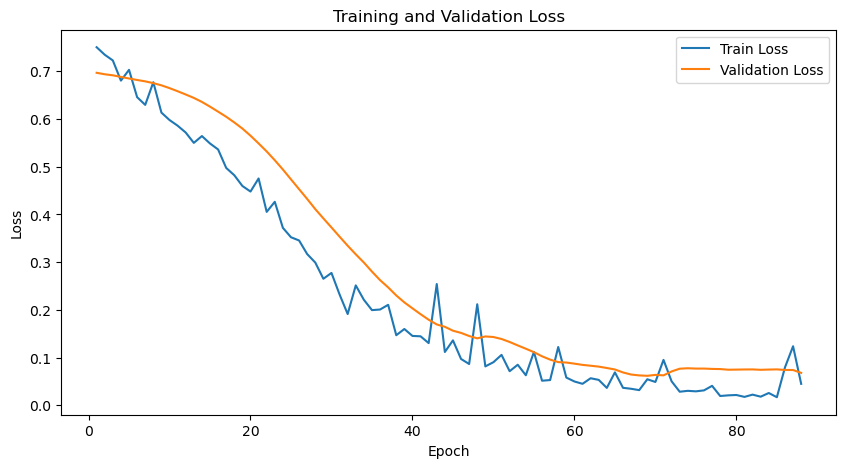

In [190]:
# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(trainer.train_losses) + 1), trainer.train_losses, label='Train Loss')
plt.plot(range(1, len(trainer.val_losses) + 1), trainer.val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

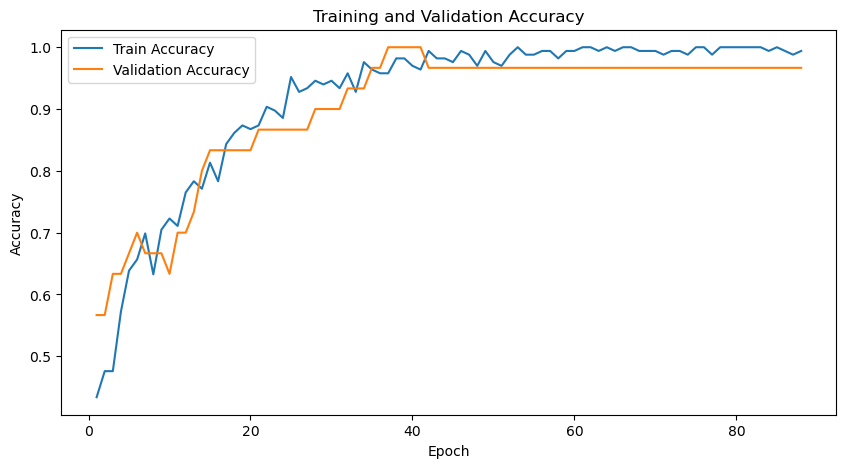

In [191]:
# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(trainer.train_accuracies) + 1), trainer.train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(trainer.val_accuracies) + 1), trainer.val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

### Results on validation data

In [192]:
# predictions returned by trainer on validation data
print("\nEvaluation on Validation Set")
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=['Control', 'Covid']))


Evaluation on Validation Set
Classification Report:
              precision    recall  f1-score   support

     Control       0.92      1.00      0.96        11
       Covid       1.00      0.95      0.97        19

    accuracy                           0.97        30
   macro avg       0.96      0.97      0.96        30
weighted avg       0.97      0.97      0.97        30



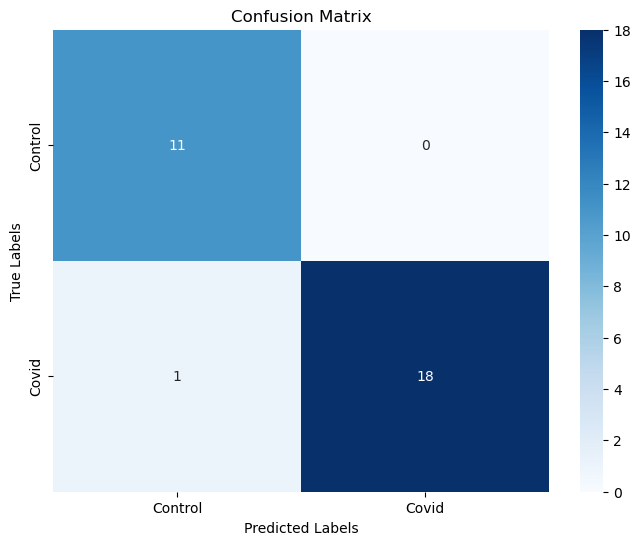

In [193]:
# Plot Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Control', 'Covid'], yticklabels=['Control', 'Covid'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Results on test

In [194]:
all_preds_test, all_labels_test = trainer.predict(test_dataset)

In [195]:
# Generate classification report
report = classification_report(all_labels_test, all_preds_test, target_names=['Control', 'Covid'])
print(report)   

              precision    recall  f1-score   support

     Control       1.00      0.92      0.96        13
       Covid       0.96      1.00      0.98        22

    accuracy                           0.97        35
   macro avg       0.98      0.96      0.97        35
weighted avg       0.97      0.97      0.97        35



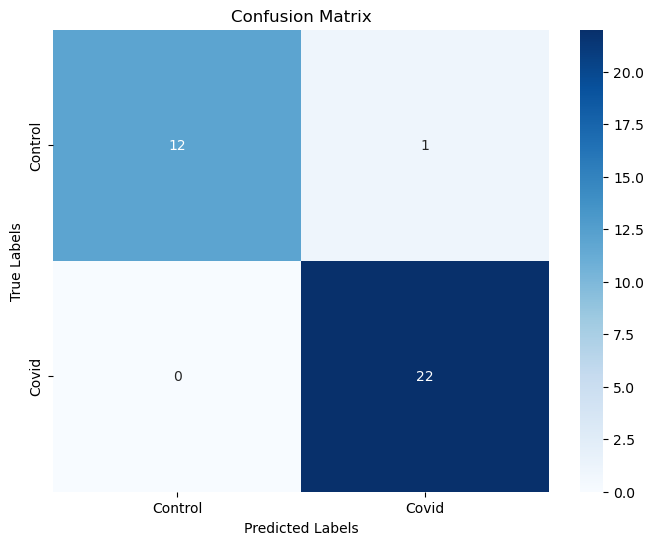

In [196]:
# Plot Confusion Matrix
cm = confusion_matrix(all_labels_test, all_preds_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Control', 'Covid'], yticklabels=['Control', 'Covid'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [198]:
trainer.save_model('../models/1dcnn_model')
X_train.to_csv('../analysis/X_train.csv', index=False)
pd.DataFrame(Y_train).to_csv('../analysis/Y_train.csv', index=False)
X_test.to_csv('../analysis/X_test.csv', index=False)
pd.DataFrame(Y_test).to_csv('../analysis/Y_test.csv', index=False)
X_val.to_csv('../analysis/X_val.csv', index=False)
pd.DataFrame(Y_val).to_csv('../analysis/Y_val.csv', index=False)